In [27]:
import pandas as pd
import numpy as np

In [2]:
def get_returns_df(df, N=1, log=False):
    if log:
        return np.log(df / df.shift(N)).iloc[N-1:].fillna(0)
    else:
        return df.pct_change(N, fill_method=None).iloc[N-1:].fillna(0)

def get_cum_returns_df(return_df, log=False):
    if log:
        return np.exp(return_df.cumsum())
    else:
        return (1 + return_df).cumprod()    # same with (return_df.cumsum() + 1)

def get_CAGR_series(cum_rtn_df, num_day_in_year=250):
    cagr_series = cum_rtn_df.iloc[-1]**(num_day_in_year/(len(cum_rtn_df))) - 1
    return cagr_series

def get_sharpe_ratio(log_rtn_df, yearly_rfr = 0.025):
    excess_rtns = log_rtn_df.mean()*252 - yearly_rfr
    return excess_rtns / (log_rtn_df.std() * np.sqrt(252))

def get_drawdown_infos(cum_returns_df):
    # 1. Drawdown
    cummax_df = cum_returns_df.cummax()
    dd_df = cum_returns_df / cummax_df - 1

    # 2. Maximum drawdown
    mdd_series = dd_df.min()

    # 3. longest_dd_period
    dd_duration_info_list = list()
    max_point_df = dd_df[dd_df == 0]
    for col in max_point_df:
        _df = max_point_df[col]
        _df.loc[dd_df[col].last_valid_index()] = 0
        _df = _df.dropna()

        periods = _df.index[1:] - _df.index[:-1]

        days = periods.days
        max_idx = days.argmax()

        longest_dd_period = days.max()
        dd_mean = int(np.mean(days))
        dd_std = int(np.std(days))

        dd_duration_info_list.append(
            [
                dd_mean,
                dd_std,
                longest_dd_period,
                "{} ~ {}".format(_df.index[:-1][max_idx].date(), _df.index[1:][max_idx].date())
            ]
        )

    dd_duration_info_df = pd.DataFrame(
        dd_duration_info_list,
        index=dd_df.columns,
        columns=['drawdown mean', 'drawdown std', 'longest days', 'longest period']
    )
    return dd_df, mdd_series, dd_duration_info_df

In [3]:
from functools import reduce

def calculate_portvals(price_df, weight_df):
    cum_rtn_up_until_now = 1
    individual_port_val_df_list = []

    prev_end_day = weight_df.index[0]
    for end_day in weight_df.index[1:]:
        sub_price_df = price_df.loc[prev_end_day:end_day]
        sub_asset_flow_df = sub_price_df / sub_price_df.iloc[0]

        weight_series = weight_df.loc[prev_end_day]
        indi_port_cum_rtn_series = (sub_asset_flow_df * weight_series) * cum_rtn_up_until_now

        individual_port_val_df_list.append(indi_port_cum_rtn_series)

        total_port_cum_rtn_series = indi_port_cum_rtn_series.sum(axis=1)
        cum_rtn_up_until_now = total_port_cum_rtn_series.iloc[-1]

        prev_end_day = end_day

    individual_port_val_df = reduce(lambda x, y: pd.concat([x, y.iloc[1:]]), individual_port_val_df_list)
    return individual_port_val_df

def get_rebal_dates(price_df, period="month"):
    _price_df = price_df.reset_index()
    if period == "month":
         groupby = [_price_df['date_time'].dt.year, _price_df['date_time'].dt.month]
    elif period == "quarter":
        groupby = [_price_df['date_time'].dt.year, _price_df['date_time'].dt.quarter]
    elif period == "halfyear":
        groupby = [_price_df['date_time'].dt.year, _price_df['date_time'].dt.month // 7]
    elif period == "year":
        groupby = [_price_df['date_time'].dt.year, _price_df['date_time'].dt.year]
    rebal_dates = pd.to_datetime(_price_df.groupby(groupby)['date_time'].last().values)
    return rebal_dates

In [4]:
result_portval_dict = {}

In [5]:
# Buy and Hold
all_ticker_price_df = pd.read_csv("../data/sample/us_etf_2.csv", index_col=0, parse_dates=True)
price_df = all_ticker_price_df[['QQQ', 'IEF']].dropna()

individual_port_val_df = price_df / price_df.iloc[0] * [0.5, 0.5]
result_portval_dict['buy_and_hold'] = individual_port_val_df.sum(axis=1)

SPY 2000-01-03 00:00:00
VEA 2007-07-26 00:00:00
EEM 2003-04-11 00:00:00
AGG 2003-09-26 00:00:00
LQD 2002-07-26 00:00:00
SHY 2002-07-26 00:00:00
IEF 2002-07-26 00:00:00


<Axes: xlabel='date_time'>

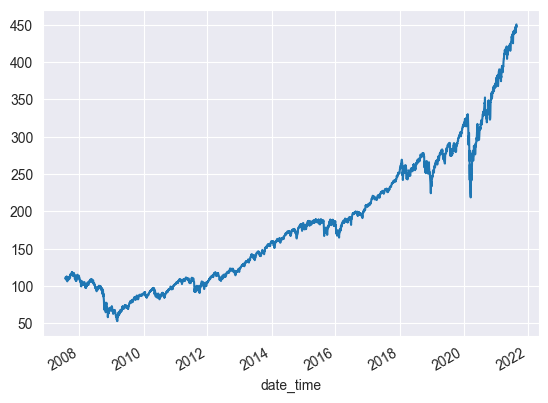

In [6]:
## Basic DAA
offense_assets = ["SPY", "VEA", "EEM", "AGG"]
defense_assets = ["LQD", "SHY", "IEF"]

all_ticker_price_df = pd.read_csv("../data/sample/us_etf_2.csv", index_col=0, parse_dates=True)
price_df = all_ticker_price_df[
    offense_assets + defense_assets
]

# 각 종목의 첫번째 상장일을 보고싶은 경우
for col in price_df.columns:
    print(col, price_df[col].first_valid_index())

price_df = price_df.dropna()
rebal_dates = get_rebal_dates(price_df)

price_df['SPY'].plot()


In [7]:
# 모멘텀 계산
momentum_df = price_df.loc[rebal_dates].copy()

momentum_result_df = (12 * momentum_df.pct_change(1)) + (4 * momentum_df.pct_change(3)) \
                                                      + (2 * momentum_df.pct_change(6)) \
                                                      + (1 * momentum_df.pct_change(12))

momentum_result_df = momentum_result_df.dropna()

array([[<Axes: title={'center': 'SPY'}>, <Axes: title={'center': 'VEA'}>],
       [<Axes: title={'center': 'EEM'}>, <Axes: title={'center': 'AGG'}>]],
      dtype=object)

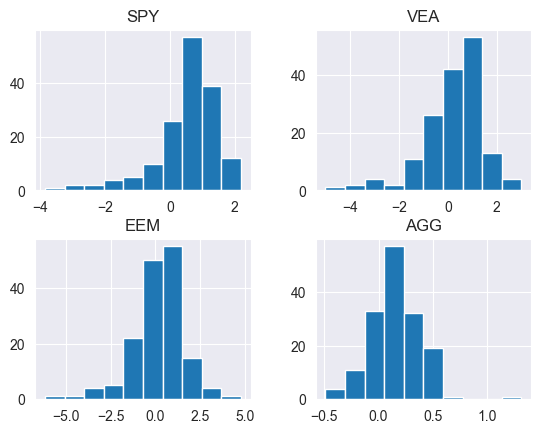

In [8]:
# 공격형 자산 시각화
is_defense_series = (momentum_result_df[offense_assets] < 0).any(axis=1)

momentum_result_df[offense_assets].hist()

In [9]:
# 공격형 자산 asset flow
offense_momentum_df = momentum_result_df[offense_assets]

offense_weight_df = offense_momentum_df.where(
    offense_momentum_df.eq(
        offense_momentum_df.max(axis=1),
        axis=0
    ),
)

offense_weight_df = (~offense_weight_df.isna()).astype(int)

# 방어형 자산 asset flow
defense_momentum_df = momentum_result_df[defense_assets]

defense_weight_df = defense_momentum_df.where(
    defense_momentum_df.eq(
        defense_momentum_df.max(axis=1),
        axis=0
    ),
)

defense_weight_df = (~defense_weight_df.isna()).astype(int)

# 공격형 자산 + 방어형 자산
target_weight_df = pd.concat(
    [
        defense_weight_df.loc[is_defense_series],
        offense_weight_df.loc[~is_defense_series],
    ]
)

target_weight_df = target_weight_df.fillna(0).astype(int)
target_weight_df = target_weight_df.sort_index()

,Sharpe Ratio
portval,0.578323


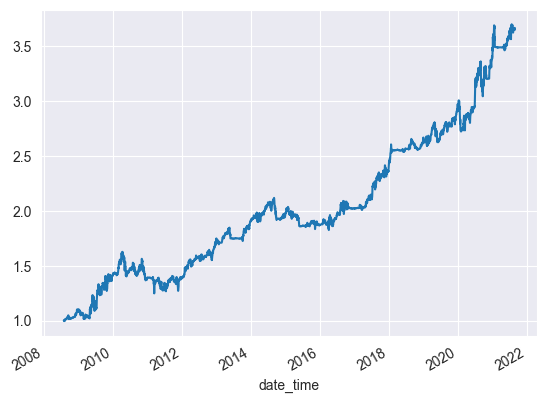

In [10]:
# VAA 포트폴리오 평가
individual_port_val_df = calculate_portvals(price_df, target_weight_df)

result_portval_dict['vaa'] = individual_port_val_df.sum(axis=1)
result_portval_dict['vaa'].plot()

# Sharpe Ratio
portval_df = result_portval_dict['vaa'].to_frame("portval")
get_sharpe_ratio(get_returns_df(portval_df, log=True)).to_frame("Sharpe Ratio")

In [11]:
# 연평균수익률
get_CAGR_series(portval_df).to_frame("CAGR")

,CAGR
portval,0.103592


<Axes: xlabel='date_time'>

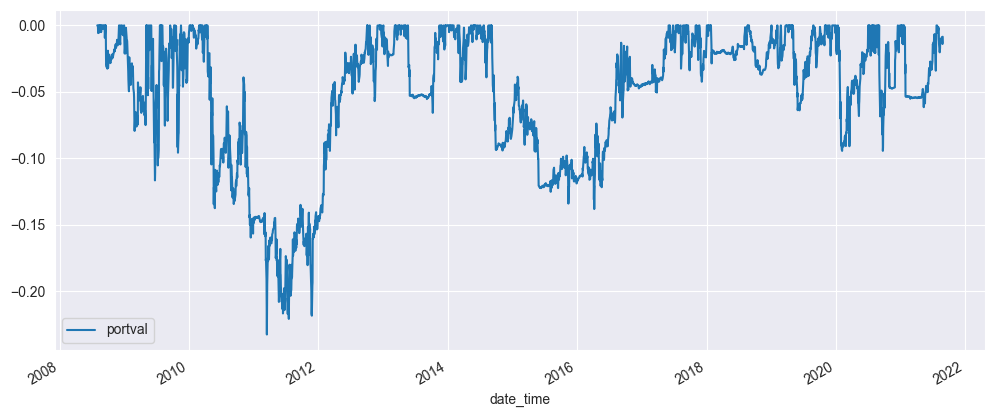

In [12]:
# MDD
dd_df, mdd_series, longest_dd_period_df = get_drawdown_infos(portval_df)
dd_df.plot(figsize=(12, 5))

In [13]:
## Basic DAA
offense_assets = ["SPY", "IWM", "QQQ", "VGK", "EWJ", "VWO", "VNQ", "GSG", "GLD", "HYG", "LQD",]
defense_assets = ["SHV", "IEF", "TLT"]  # UST대신 TLT로 대체
canary_assets = ["VWO", "BND"]   # VWO는 offense_asset에도 존재

all_ticker_price_df = pd.read_csv("../data/sample/us_etf_2.csv", index_col=0, parse_dates=True)
price_df = all_ticker_price_df[
    list(set(offense_assets + defense_assets + canary_assets))
]

price_df = price_df.dropna()
rebal_dates = get_rebal_dates(price_df)

In [14]:
momentum_df = price_df.loc[rebal_dates].copy()

momentum_result_df = (12 * momentum_df.pct_change(1)) + (4 * momentum_df.pct_change(3)) \
                                                      + (2 * momentum_df.pct_change(6)) \
                                                      + (1 * momentum_df.pct_change(12))

momentum_result_df = momentum_result_df.dropna()

In [15]:
# 카나리 신호 계산
canary_signal_series = (momentum_result_df[canary_assets] > 0).sum(axis=1)

momentum_result_df['canary_signal'] = canary_signal_series

In [16]:
def set_weight(series):
    canary_score = series.loc["canary_signal"]
    if canary_score == 0:
        target_assets = series.loc[defense_assets].sort_values().iloc[-1:].index
        return pd.Series([1], index=target_assets)
    elif canary_score == 1:
        target_assets1 = series.loc[offense_assets].sort_values().iloc[-2:].index
        target_assets2 = series.loc[defense_assets].sort_values().iloc[-1:].index
        return pd.Series(
            [0.25, 0.25, 0.5],
            index=target_assets1.tolist() + target_assets2.tolist()
        )
    else:
        target_assets = series.loc[offense_assets].sort_values().iloc[-2:].index
        return pd.Series([0.5, 0.5], index=target_assets)

target_weight_df = momentum_result_df.apply(set_weight, axis=1).fillna(0)

,Sharpe Ratio
portval,0.727753


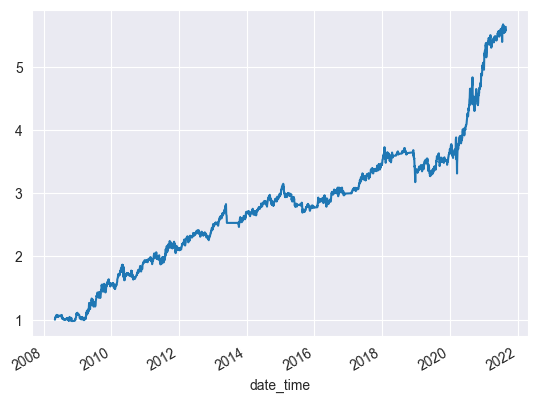

In [17]:
# DAA 포트폴리오 평가
individual_port_val_df = calculate_portvals(price_df, target_weight_df)

result_portval_dict['daa'] = individual_port_val_df.sum(axis=1)
result_portval_dict['daa'].plot()

portval_df = result_portval_dict['daa'].to_frame("portval")
get_sharpe_ratio(get_returns_df(portval_df, log=True)).to_frame("Sharpe Ratio")

In [18]:
get_CAGR_series(portval_df).to_frame("CAGR")

,CAGR
portval,0.137425


<Axes: xlabel='date_time'>

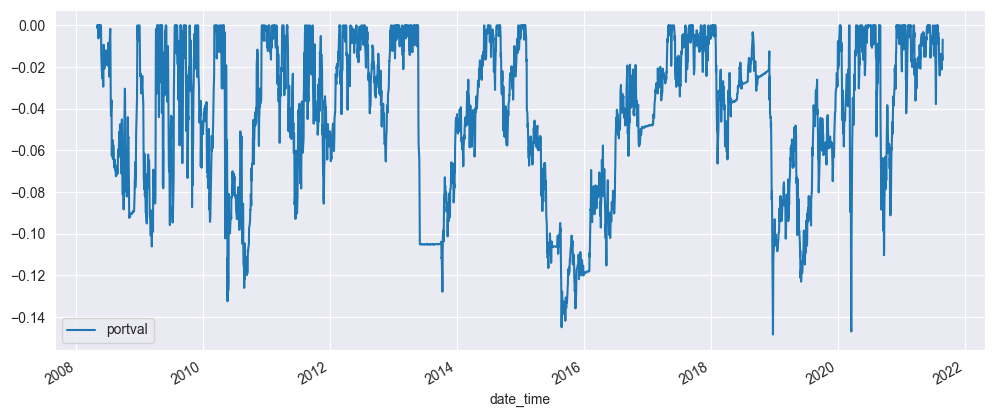

In [19]:
dd_df, mdd_series, longest_dd_period_df = get_drawdown_infos(portval_df)
dd_df.plot(figsize=(12, 5))

<Axes: xlabel='date_time'>

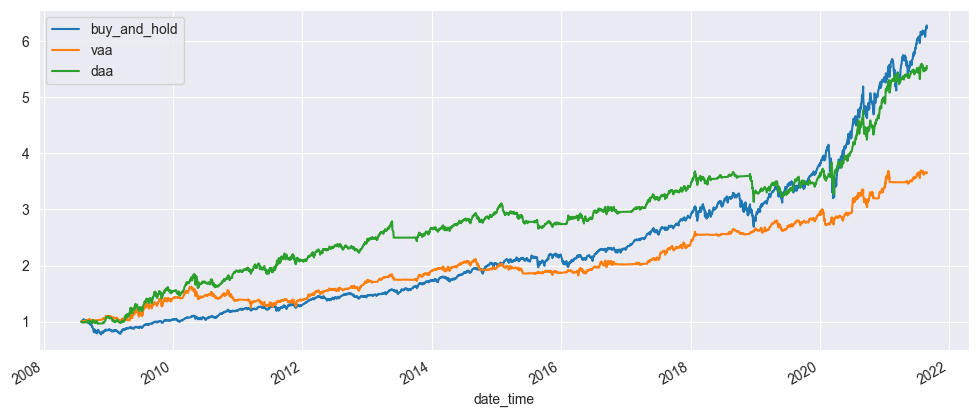

In [20]:
# 포트폴리오 종합 비교
compare_df = pd.DataFrame(result_portval_dict).dropna()
compare_df = compare_df / compare_df.iloc[0]
compare_df.plot(figsize=(12, 5))

In [21]:
get_sharpe_ratio(get_returns_df(compare_df, log=True)).sort_values(ascending=False).to_frame("Sharpe Ratio")

,Sharpe Ratio
buy_and_hold,0.803849
daa,0.736062
vaa,0.578323


In [22]:
get_CAGR_series(compare_df).sort_values(ascending=False).to_frame("CAGR")

,CAGR
buy_and_hold,0.149757
daa,0.139135
vaa,0.103592


<Axes: xlabel='date_time'>

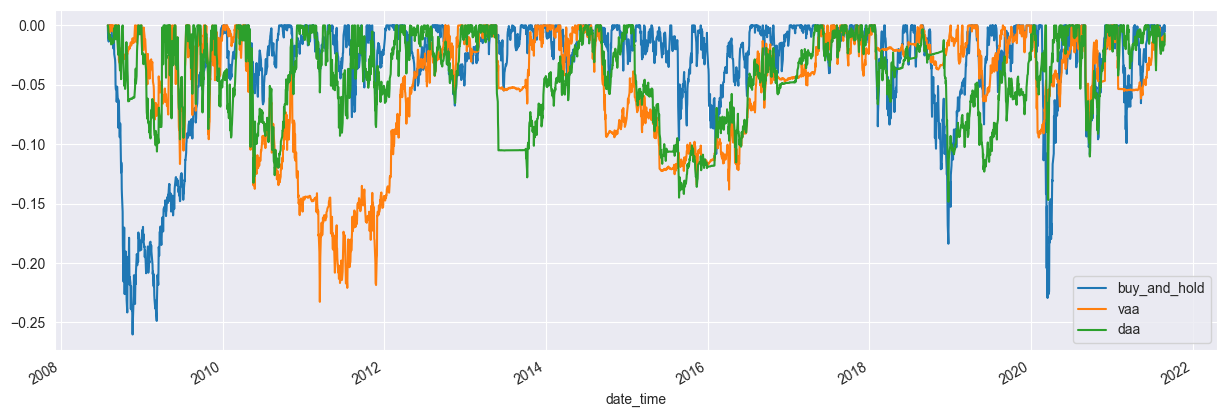

In [23]:
dd_df, mdd_series, longest_dd_period_df = get_drawdown_infos(compare_df)
dd_df.plot(figsize=(15, 5))

In [24]:
mdd_series.sort_values().to_frame("MDD")

,MDD
buy_and_hold,-0.260105
vaa,-0.232617
daa,-0.148401


In [25]:
longest_dd_period_df

,drawdown mean,drawdown std,longest days,longest period
buy_and_hold,8,30,507,2008-08-15 ~ 2010-01-04
vaa,17,85,1000,2014-09-05 ~ 2017-06-01
daa,15,68,823,2015-01-29 ~ 2017-05-01


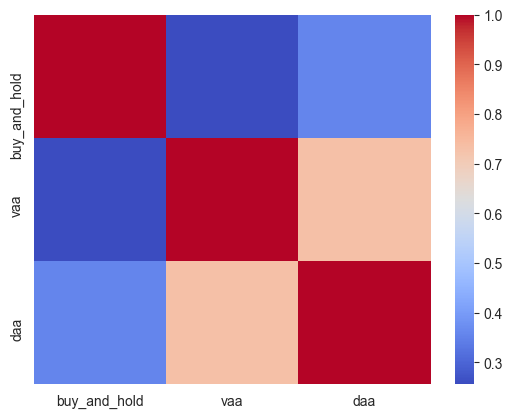

In [26]:
import seaborn as sns

# 포트폴리오 상관관계 히트맵
sns.heatmap(compare_df.pct_change().corr(), cmap="coolwarm");